In [1]:
using ITensors
using ITensorMPS
using LinearAlgebra
using Statistics
using Plots
using ProgressMeter
using Random
using GLM
using DataFrames
using ITensorCorrelators

Random.seed!(42)

TaskLocalRNG()

In [14]:
println("Number of threads available: ", Threads.nthreads())
println("Thread pool size: ", Threads.threadpoolsize())

Number of threads available: 10
Thread pool size: 10


In [2]:
function create_plus_state_mps(L::Int)
    sites = siteinds("S=1/2", L)

    state = ["+" for _ in 1:L]
    ψ = productMPS(sites, state)
    
    return ψ, sites
end

create_plus_state_mps (generic function with 1 method)

In [3]:
function apply_single_site_gate(ψ::MPS, site::Int, gate::ITensor; 
                                maxdim::Int=128, cutoff::Float64=1e-12)
    ψ_new = copy(ψ)
    ψ_new[site] = gate * ψ_new[site]
    noprime!(ψ_new[site])  # Remove prime indices for consistency

    if maxlinkdim(ψ_new) > maxdim
        ψ_new = truncate(ψ_new; maxdim=maxdim, cutoff=cutoff)
    end
    
    return ψ_new
end

function apply_two_site_gate(ψ::MPS, site1::Int, site2::Int, gate::ITensor; 
                            maxdim::Int=128, cutoff::Float64=1e-12)
    if abs(site1 - site2) == 1
        s1, s2 = min(site1, site2), max(site1, site2)
        return product(gate, ψ, [s1, s2]; maxdim=maxdim, cutoff=cutoff)
    else
        return ψ  # No operation for non-adjacent sites
    end
end

apply_two_site_gate (generic function with 1 method)

In [4]:
function calculate_entropy(ψ::MPS, cut::Int)
    L = length(ψ)
    if cut <= 0 || cut >= L
        return 0.0
    end
    
    try
        # Create copy and move orthogonality center to cut position
        # This ensures proper Schmidt decomposition across the cut
        ψ_copy = copy(ψ)
        orthogonalize!(ψ_copy, cut)
        
        # Get bond between sites cut and cut+1
        if cut < L
            bond_idx = commonind(ψ_copy[cut], ψ_copy[cut+1])
            if bond_idx !== nothing
                # Perform singular value decomposition: M = USV†
                U, S, V = svd(ψ_copy[cut], (bond_idx,))
                
                # Extract Schmidt values (singular values)
                schmidt_vals = Float64[]
                for i in 1:dim(S, 1)
                    val = S[i,i]
                    if abs(val) > 1e-12  # Numerical cutoff
                        push!(schmidt_vals, abs(val))
                    end
                end
                
                if isempty(schmidt_vals)
                    return 0.0
                end
                
                # Normalize Schmidt values (should already be normalized, but ensure)
                schmidt_vals = schmidt_vals ./ norm(schmidt_vals)
                
                # Calculate von Neumann entropy: S = -Σ λᵢ log₂(λᵢ)
                # where λᵢ = (Schmidt value)² are the Schmidt coefficients
                entropy = -sum(s^2 * log2(s^2 + 1e-16) for s in schmidt_vals)
                return entropy
            end
        end
        
        return 0.0
    catch e
        println("Warning: Entropy calculation failed for cut=$cut: $e")
        return 0.0
    end
end

calculate_entropy (generic function with 1 method)

In [5]:
function create_weak_measurement_operators(sites, lambda_x::Float64, lambda_zz::Float64)
    WEAK_X_0 = Dict()
    WEAK_X_1 = Dict()
    
    WEAK_ZZ_0 = Dict()
    WEAK_ZZ_1 = Dict()
    
    norm_x = sqrt(2 * (1 + lambda_x^2))
    norm_zz = sqrt(2 * (1 + lambda_zz^2))
    
    # Create weak X operators for each site
    for i in 1:length(sites)
        Id_i = op("Id", sites[i])
        X_i = op("X", sites[i])
        
        # K_0 = (I + λ_x X) / √(2(1 + λ_x²))
        WEAK_X_0[i] = (Id_i + lambda_x * X_i) / norm_x
        # K_1 = (I - λ_x X) / √(2(1 + λ_x²))  
        WEAK_X_1[i] = (Id_i - lambda_x * X_i) / norm_x
    end
    
    # Create weak ZZ operators for adjacent pairs
    for i in 1:(length(sites)-1)
        Z_i = op("Z", sites[i])
        Z_j = op("Z", sites[i+1])
        Id_i = op("Id", sites[i])
        Id_j = op("Id", sites[i+1])
        
        ZZ = Z_i * Z_j
        II = Id_i * Id_j
        
        # K_0 = (II + λ_zz ZZ) / √(2(1 + λ_zz²))
        WEAK_ZZ_0[(i, i+1)] = (II + lambda_zz * ZZ) / norm_zz
        # K_1 = (II - λ_zz ZZ) / √(2(1 + λ_zz²))
        WEAK_ZZ_1[(i, i+1)] = (II - lambda_zz * ZZ) / norm_zz
    end
    
    return WEAK_X_0, WEAK_X_1, WEAK_ZZ_0, WEAK_ZZ_1
end

create_weak_measurement_operators (generic function with 1 method)

In [6]:
function apply_weak_x_measurement(ψ::MPS, site::Int, prob::Float64,
                                 WEAK_X_0::Dict, WEAK_X_1::Dict;
                                 maxdim::Int=128, cutoff::Float64=1e-12)
    # Skip measurement with probability (1-prob)
    if rand() >= prob
        return ψ
    end
    
    ψ_0 = apply_single_site_gate(ψ, site, WEAK_X_0[site]; maxdim=maxdim, cutoff=cutoff)
    ψ_1 = apply_single_site_gate(ψ, site, WEAK_X_1[site]; maxdim=maxdim, cutoff=cutoff)
    
    prob_0 = real(inner(ψ_0, ψ_0))
    prob_1 = real(inner(ψ_1, ψ_1))
    
    prob_0 = max(prob_0, 0.0)
    prob_1 = max(prob_1, 0.0)
    total_prob = prob_0 + prob_1
    
    # Handle edge case
    if total_prob < 1e-12
        return nothing
    end
    
    prob_0 /= total_prob
    prob_1 /= total_prob
    
    # Randomly choose outcome based on quantum probabilities
    if rand() < prob_0
        if prob_0 < 1e-12
            return nothing
        end
        normalize!(ψ_0)
        return ψ_0
    else
        if prob_1 < 1e-12
            return nothing
        end
        normalize!(ψ_1)
        return ψ_1
    end
end

function apply_weak_zz_measurement(ψ::MPS, site1::Int, site2::Int, prob::Float64,
                                  WEAK_ZZ_0::Dict, WEAK_ZZ_1::Dict;
                                  maxdim::Int=128, cutoff::Float64=1e-12)
    # Skip measurement with probability (1-prob)
    if rand() >= prob
        return ψ
    end
    
    # Apply operators
    ψ_0 = apply_two_site_gate(ψ, site1, site2, WEAK_ZZ_0[(site1, site2)]; 
                             maxdim=maxdim, cutoff=cutoff)
    ψ_1 = apply_two_site_gate(ψ, site1, site2, WEAK_ZZ_1[(site1, site2)]; 
                             maxdim=maxdim, cutoff=cutoff)
    
    # Calculate probabilities
    prob_0 = real(inner(ψ_0, ψ_0))
    prob_1 = real(inner(ψ_1, ψ_1))
    
    prob_0 = max(prob_0, 0.0)
    prob_1 = max(prob_1, 0.0)
    total_prob = prob_0 + prob_1
    
    if total_prob < 1e-12
        return nothing
    end
    
    prob_0 /= total_prob
    prob_1 /= total_prob
    
    if rand() < prob_0
        if prob_0 < 1e-12
            return nothing
        end
        normalize!(ψ_0)
        return ψ_0
    else
        if prob_1 < 1e-12
            return nothing
        end
        normalize!(ψ_1)
        return ψ_1
    end
end

apply_weak_zz_measurement (generic function with 1 method)

In [7]:
function run_single_trial_weak(seed::Int, L::Int, T_max::Int, lambda_x::Float64, lambda_zz::Float64, 
                              cuts::Vector{Int}; maxdim::Int=128, cutoff::Float64=1e-12, 
                              periodic::Bool=false)

    Random.seed!(seed)
    
    ψ, sites = create_up_state_mps(L)  # Changed to UP states as specified by user
    
    WEAK_X_0, WEAK_X_1, WEAK_ZZ_0, WEAK_ZZ_1 = create_weak_measurement_operators(sites, lambda_x, lambda_zz)
    
    for t in 1:T_max
        # Apply weak X measurements on all sites
        for i in 1:L
            ψ = apply_weak_x_measurement(ψ, i, 1.0, WEAK_X_0, WEAK_X_1; 
                                        maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                return fill(NaN, length(cuts))
            end
        end
        
        # Apply weak ZZ measurements on adjacent pairs
        for i in 1:(L-1)
            ψ = apply_weak_zz_measurement(ψ, i, i+1, 1.0, WEAK_ZZ_0, WEAK_ZZ_1;
                                         maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                return fill(NaN, length(cuts))
            end
        end
        
        if periodic && L > 2
            # no loop
        end
    end
    
    entropies = [calculate_entropy(ψ, cut) for cut in cuts]
    return entropies
end

run_single_trial_weak (generic function with 1 method)

In [8]:
function run_parallel_simulation_weak(L::Int, T_max::Int, lambda_x::Float64, lambda_zz::Float64, 
                                      cuts::Vector{Int}, num_trials::Int; seed::Int=42, 
                                      maxdim::Int=128, cutoff::Float64=1e-12, periodic::Bool=false)

    seeds = [seed + i for i in 0:(num_trials-1)]
    all_results = Vector{Vector{Float64}}(undef, num_trials)
    
    println("Running $(num_trials) weak measurement trials on $(Threads.nthreads()) threads...")
    println("Parameters: λ_x = $lambda_x, λ_zz = $lambda_zz, periodic = $periodic")
    
    # Run trials in parallel
    @showprogress desc="Weak measurement simulation: " Threads.@threads for idx in 1:num_trials
        all_results[idx] = run_single_trial_weak(seeds[idx], L, T_max, lambda_x, lambda_zz, cuts; 
                                                 maxdim=maxdim, cutoff=cutoff, periodic=periodic)
    end
    
    # Compute averages and standard errors
    results_matrix = hcat(all_results...)'
    avg_entropies = Float64[]
    std_errors = Float64[]
    
    for i in 1:length(cuts)
        valid_results = filter(!isnan, results_matrix[:, i])
        if !isempty(valid_results)
            push!(avg_entropies, mean(valid_results))
            push!(std_errors, std(valid_results) / sqrt(length(valid_results)))
        else
            push!(avg_entropies, NaN)
            push!(std_errors, NaN)
        end
    end
    
    return avg_entropies, std_errors
end

run_parallel_simulation_weak (generic function with 1 method)

In [9]:
function analyze_weak_entanglement_scaling(L::Int, T_max::Int, lambda_x::Float64, lambda_zz::Float64, 
                                          num_trials::Int; seed::Int=42, maxdim::Int=128, 
                                          cutoff::Float64=1e-12, show_error_bars::Bool=true,
                                          periodic::Bool=false)

    cuts = collect(0:L)
    
    avg_entropies, std_errors = run_parallel_simulation_weak(L, T_max, lambda_x, lambda_zz, 
                                                            cuts, num_trials; 
                                                            seed=seed, maxdim=maxdim, 
                                                            cutoff=cutoff, periodic=periodic)
    
    # Plot entropy vs cut size
    x_values = Float64.(cuts)
    if show_error_bars && !all(isnan.(std_errors))
        p1 = plot(x_values, avg_entropies, yerror=std_errors, marker=:circle, 
                 label="Weak measurement data", markersize=4, linewidth=2)
    else
        p1 = plot(x_values, avg_entropies, marker=:circle, label="Weak measurement data", 
                 markersize=4, linewidth=2)
    end
    
    xlabel!("Cut position ℓ")
    ylabel!("Entanglement entropy S(ℓ)")
    boundary_type = periodic ? "periodic" : "open"
    title!("Weak Measurement Entanglement Entropy\n(L=$L, λₓ=$lambda_x, λ_zz=$lambda_zz, $boundary_type, $(num_trials) trials)")
    plot!(grid=true, gridwidth=1, gridcolor=:lightgray, gridalpha=0.5)
    plot!(size=(800, 600), margin=5Plots.mm)
    display(p1)
    
    # CFT scaling analysis (exclude boundary cuts)
    inner_cuts = cuts[2:end-1]
    inner_entropies = avg_entropies[2:end-1]
    
    # Filter out NaN values
    valid_idx = findall(!isnan, inner_entropies)
    if length(valid_idx) > 3
        valid_cuts = inner_cuts[valid_idx]
        valid_entropies = inner_entropies[valid_idx]
        
        # Transform to conformal field theory scaling variable
        x_cft = log.((L / π) .* sin.(π .* Float64.(valid_cuts) ./ L))
        
        # Linear regression
        data = DataFrame(x=x_cft, y=valid_entropies)
        model = lm(@formula(y ~ x), data)
        slope = coef(model)[2]
        intercept = coef(model)[1]
        r_squared = r2(model)
        
        p2 = plot(x_cft, valid_entropies, marker=:circle, label="Data", markersize=4)
        plot!(x_cft, slope .* x_cft .+ intercept, linestyle=:dash, linewidth=2,
              label="Linear fit (slope=$(round(slope, digits=3)), R²=$(round(r_squared, digits=3)))")
        xlabel!("log(L/π × sin(π×ℓ/L))")
        ylabel!("Entanglement entropy S(ℓ)")
        title!("Weak Measurement CFT Scaling Analysis\n(Central charge c ≈ 6 × slope)")
        plot!(grid=true, gridwidth=1, gridcolor=:lightgray, gridalpha=0.5)
        plot!(size=(800, 600), margin=5Plots.mm)
        display(p2)

        
        c_eff = 6 * slope
        
        return avg_entropies, std_errors, slope, r_squared, c_eff
    else
        println("Warning: Not enough valid data points for regression analysis")
        return avg_entropies, std_errors, NaN, NaN, NaN
    end
end

analyze_weak_entanglement_scaling (generic function with 1 method)

Analyzing weak measurement entanglement scaling:
L=20, T_max=60, λ_x=0.5, λ_zz=0.5
Running 100 weak measurement trials on 10 threads...
Parameters: λ_x = 0.5, λ_zz = 0.5, periodic = false


Weak measurement simulation: 100%|██████████████████████| Time: 0:02:30


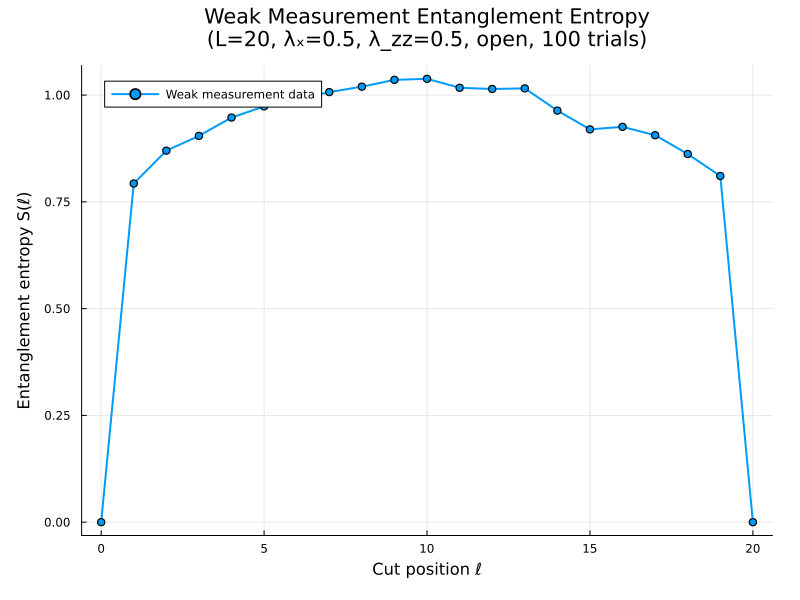

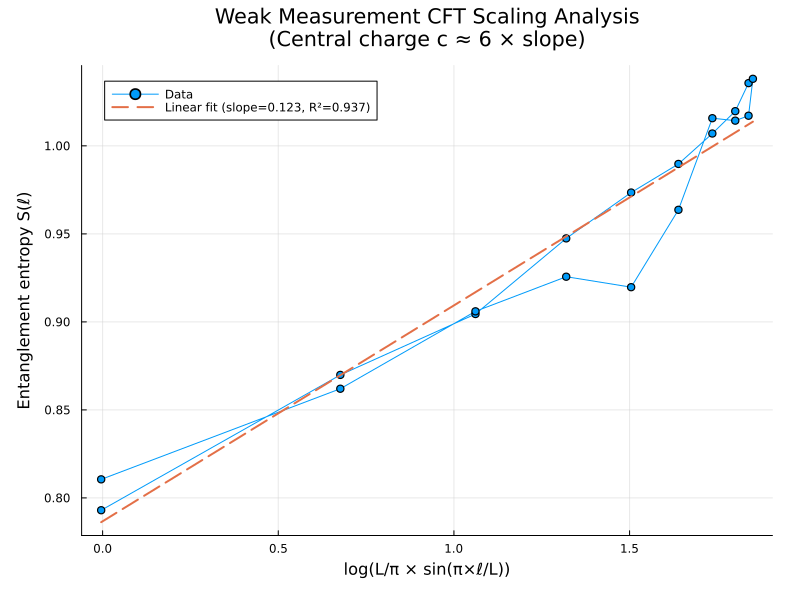

154.753196 seconds (2.94 G allocations: 1.015 TiB, 39.67% gc time, 1 lock conflict, 95.38% compilation time: <1% of which was recompilation)


([0.0, 0.7930007433118598, 0.8698823703700456, 0.9044630603096099, 0.9474318117072928, 0.973488752926198, 0.9897259035717711, 1.0070136262763176, 1.0197064522928905, 1.0356436256972754  …  1.0171143236150695, 1.014315890371214, 1.0157131134717203, 0.9636687722855676, 0.9197106981533096, 0.9256607951049333, 0.9060016659828076, 0.8620252337513478, 0.8105468954393428, 0.0], [0.0, 0.015060811569794214, 0.01815500731033998, 0.020458025930961504, 0.02282251972143718, 0.026076925291606323, 0.026298737426316738, 0.024330253422588866, 0.024743148584281338, 0.02388360045896651  …  0.023888934485886366, 0.023798703744922833, 0.02405176292507593, 0.022826848875172757, 0.021708622798884115, 0.0198655482572435, 0.01662742643263484, 0.018396191892050003, 0.013841600934769199, 0.0], 0.12264649588011765, 0.9372520472570115, 0.7358789752807059)

In [ ]:
L = 20
T_max = 60         
lambda_x = 0.5     
lambda_zz = 0.5    
num_trials = 100    
seed = 42          

@time begin
    avg_entropies, std_errors, slope, r_squared, c_eff = analyze_weak_entanglement_scaling(
        L, T_max, lambda_x, lambda_zz, num_trials;
        seed=seed,
        maxdim=64,             
        cutoff=1e-12,           # SVD cutoff for truncation  
        show_error_bars=false, 
        periodic=false     
    )
end

In [10]:
function run_single_trial_weak_time_series(
    seed::Int,
    L::Int,
    T_max::Int,
    λ_x::Float64,
    λ_zz::Float64,
    cuts::Vector{Int};
    maxdim::Int = 128,
    cutoff::Float64 = 1e-12,
    periodic::Bool = false,
)
    Random.seed!(seed)
    ψ, sites = create_up_state_mps(L)  # Changed to UP states as specified by user
    WX0, WX1, WZ0, WZ1 = create_weak_measurement_operators(sites, λ_x, λ_zz)

    S_traj = Vector{Float64}(undef, T_max + 1)
    
    # Calculate initial entropy (t=0, before any measurements)
    ent_initial = [calculate_entropy(ψ, c) for c in cuts]
    S_traj[1] = mean(ent_initial)

    for t in 1:T_max
        for i in 1:L
            ψ = apply_weak_x_measurement(ψ, i, 1.0, WX0, WX1; maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                fill!(S_traj[(t+1):end], NaN)
                return S_traj
            end
        end
        for i in 1:(L-1)
            ψ = apply_weak_zz_measurement(ψ, i, i+1, 1.0, WZ0, WZ1; maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                fill!(S_traj[(t+1):end], NaN)
                return S_traj
            end
        end
        
        ent = [calculate_entropy(ψ, c) for c in cuts]
        S_traj[t+1] = mean(ent)
    end

    return S_traj
end

using ProgressMeter
import Base.Threads: @threads, nthreads
using Statistics

function simulate_S_time_series(
    L::Int,
    T_max::Int,
    λ_x::Float64,
    λ_zz::Float64,
    cuts::Vector{Int},
    num_trials::Int;
    seed::Int = 42,
    maxdim::Int = 128,
    cutoff::Float64 = 1e-12,
    periodic::Bool = false,
)
    seeds = [seed + i for i in 0:(num_trials - 1)]
    all_trajs = Vector{Vector{Float64}}(undef, num_trials)

    println("Running $num_trials trials on $(nthreads()) threads for L=$L, T_max=$T_max")
    prog = Progress(num_trials; desc="Time‑series simulation")

    @threads for idx in 1:num_trials
        all_trajs[idx] = run_single_trial_weak_time_series(
            seeds[idx], L, T_max, λ_x, λ_zz, cuts;
            maxdim=maxdim, cutoff=cutoff, periodic=periodic
        )
        next!(prog)
    end

    M = hcat(all_trajs...)'
    S_avg = [ mean(skipmissing(M[:, t])) for t in 1:(T_max + 1) ]
    return S_avg ./ (log(L) + 2)  # Updated to use alpha = 2 for optimal data collapse
end

function plot_data_collapse(
    Ls::Vector{Int},
    T_maxs::Vector{Int},
    λ_x::Float64,
    λ_zz::Float64,
    num_trials::Int;
    seed::Int = 42,
    maxdim::Int = 128,
    cutoff::Float64 = 1e-12,
    periodic::Bool = false,
)
    plt = plot()
    for (L, T_max) in zip(Ls, T_maxs)
        cuts = [L÷2]  # Fixed: create Vector{Int} instead of Float64
        
        S_norm = simulate_S_time_series(
            L, T_max, λ_x, λ_zz, cuts, num_trials;
            seed=seed, maxdim=maxdim, cutoff=cutoff, periodic=periodic
        )
        plot!(plt,
              (0:T_max) ./ L,
              S_norm;
              label      = "L = $L",
              marker     = :circle,
              markersize = 4,
              linewidth  = 2)
    end
    xlabel!(plt, "T / L")
    ylabel!(plt, "S / (log L + 2)")  # Updated ylabel to reflect alpha = 2
    title!(plt, "Data collapse: S/(log L + 2) vs T/L")  # Updated title to reflect alpha = 2
    return plt
end

plot_data_collapse (generic function with 1 method)

Running 500 trials on 10 threads for L=8, T_max=16


Time‑series simulation 100%|█████████████████████████████| Time: 0:00:13
Time‑series simulation 100%|█████████████████████████████| Time: 0:00:13


Running 500 trials on 10 threads for L=16, T_max=32


Time‑series simulation 100%|█████████████████████████████| Time: 0:02:19



Running 500 trials on 10 threads for L=24, T_max=48


Time‑series simulation 100%|█████████████████████████████| Time: 0:13:39
Time‑series simulation 100%|█████████████████████████████| Time: 0:13:39


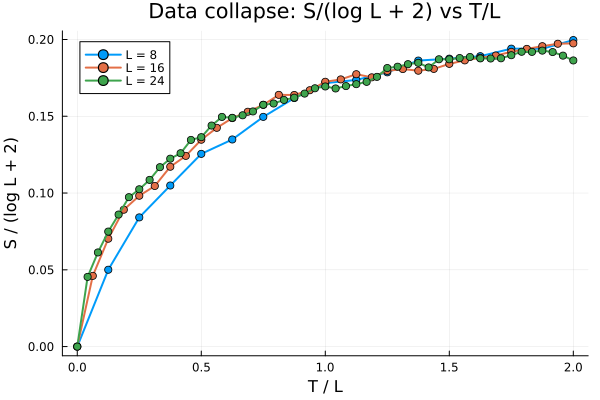

In [28]:
Ls = [8, 16, 24]
T_maxs = [16, 32, 48]
λ_x = 0.5
λ_zz = 0.5
num_trials = 500

plt = plot_data_collapse(Ls, T_maxs, λ_x, λ_zz, num_trials)
display(plt)

In [11]:
function find_optimal_alpha(Ls::Vector{Int}, T_maxs::Vector{Int}, λ_x::Float64, λ_zz::Float64, 
                          num_trials::Int; alpha_range=0.0:0.1:3.0, seed::Int=42)
    """
    Find optimal alpha for S/(log L + alpha) normalization to achieve data collapse
    """
    println("Testing alpha values from $(first(alpha_range)) to $(last(alpha_range))...")
    
    # First, get all the entropy time series data
    all_S_data = Dict()
    for (L, T_max) in zip(Ls, T_maxs)
        cuts = [L÷2]  # Use middle cut
        S_norm_raw = simulate_S_time_series(
            L, T_max, λ_x, λ_zz, cuts, num_trials;
            seed=seed, maxdim=64, cutoff=1e-12, periodic=false
        )
        all_S_data[L] = (S_norm_raw .* log(L), T_max)  # Store unnormalized entropy
    end
    
    best_alpha = 0.0
    best_variance = Inf
    alpha_results = Float64[]
    variance_results = Float64[]
    
    for alpha in alpha_range
        # Calculate normalized entropies with current alpha
        saturation_values = Float64[]
        
        for L in Ls
            S_raw, T_max = all_S_data[L]
            S_normalized = S_raw ./ (log(L) + alpha)
            
            # Take saturation value (last 20% of time series)
            saturation_start = Int(round(0.8 * length(S_normalized)))
            saturation_value = mean(S_normalized[saturation_start:end])
            push!(saturation_values, saturation_value)
        end
        
        # Calculate variance of saturation values (lower = better collapse)
        saturation_variance = var(saturation_values)
        
        push!(alpha_results, alpha)
        push!(variance_results, saturation_variance)
        
        if saturation_variance < best_variance
            best_variance = saturation_variance
            best_alpha = alpha
        end
        
        println("α = $(round(alpha, digits=2)): saturation values = $(round.(saturation_values, digits=4)), variance = $(round(saturation_variance, digits=6))")
    end
    
    println("\n" * "="^60)
    println("OPTIMAL ALPHA ANALYSIS")
    println("="^60)
    println("Best α = $(round(best_alpha, digits=2))")
    println("Minimum variance = $(round(best_variance, digits=6))")
    
    # Plot variance vs alpha
    p_alpha = plot(alpha_results, variance_results, 
                  marker=:circle, markersize=4, linewidth=2,
                  xlabel="α", ylabel="Variance of saturation values",
                  title="Finding Optimal α for Data Collapse",
                  grid=true, gridwidth=1, gridcolor=:lightgray, gridalpha=0.5)
    
    # Mark the minimum
    min_idx = argmin(variance_results)
    plot!(p_alpha, [alpha_results[min_idx]], [variance_results[min_idx]], 
          marker=:star, markersize=8, color=:red, 
          label="Optimal α = $(round(best_alpha, digits=2))")
    
    display(p_alpha)
    
    return best_alpha, all_S_data
end

find_optimal_alpha (generic function with 1 method)

Finding optimal α for data collapse...
Testing alpha values from 0.0 to 2.0...
Running 100 trials on 10 threads for L=8, T_max=16


Time‑series simulation 100%|█████████████████████████████| Time: 0:00:15


Running 100 trials on 10 threads for L=16, T_max=32


Time‑series simulation 100%|█████████████████████████████| Time: 0:00:26


Running 100 trials on 10 threads for L=24, T_max=48


Time‑series simulation 100%|█████████████████████████████| Time: 0:02:39


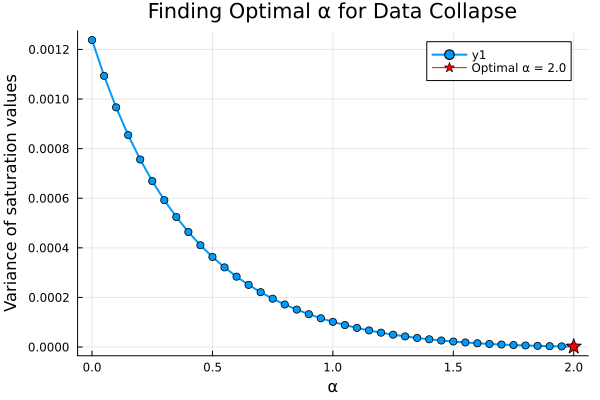

α = 0.0: saturation values = [0.3768, 0.3272, 0.3088], variance = 0.001238
α = 0.05: saturation values = [0.368, 0.3214, 0.304], variance = 0.001094
α = 0.1: saturation values = [0.3595, 0.3158, 0.2994], variance = 0.000967
α = 0.15: saturation values = [0.3515, 0.3104, 0.2949], variance = 0.000855
α = 0.2: saturation values = [0.3438, 0.3052, 0.2905], variance = 0.000756
α = 0.25: saturation values = [0.3364, 0.3002, 0.2863], variance = 0.000669
α = 0.3: saturation values = [0.3293, 0.2953, 0.2822], variance = 0.000592
α = 0.35: saturation values = [0.3225, 0.2905, 0.2782], variance = 0.000524
α = 0.4: saturation values = [0.316, 0.286, 0.2743], variance = 0.000464
α = 0.45: saturation values = [0.3098, 0.2815, 0.2705], variance = 0.000411
α = 0.5: saturation values = [0.3038, 0.2772, 0.2668], variance = 0.000363
α = 0.55: saturation values = [0.298, 0.2731, 0.2633], variance = 0.000321
α = 0.6: saturation values = [0.2925, 0.269, 0.2598], variance = 0.000284
α = 0.65: saturation valu

(2.0, Dict{Any, Any}(16 => ([-0.0, 0.20221626233880943, 0.3119129509709366, 0.42547116677269087, 0.4522368384654827, 0.5325968749862589, 0.5780060565985667, 0.5962458194193683, 0.6304760014040726, 0.6755902289926712  …  0.8578310341160049, 0.8690832565053447, 0.8823740701966362, 0.8738272339735675, 0.8805305517482404, 0.9118097896049143, 0.909072364336606, 0.9235320150177752, 0.94044092034672, 0.9362874524941958], 32), 24 => ([-0.0, 0.2207487707474198, 0.2828495691789575, 0.3831687064241604, 0.41746490556957794, 0.4860866770696877, 0.5015217122871942, 0.5539596651819854, 0.5962987020977153, 0.6292165290860107  …  1.0066750515571916, 0.9905989406749366, 0.9765636675185102, 0.9846347948615269, 0.9971553810923897, 0.9702754825140538, 0.9793376813727304, 0.9726829561810957, 0.9643731046751807, 0.9639873957390143], 48), 8 => ([-0.0, 0.20536572200584405, 0.34028093293938466, 0.4355391401371505, 0.49802403468192175, 0.5529354601495227, 0.5893145059308648, 0.6727200011138527, 0.682793280558852

In [14]:
# Find optimal alpha for data collapse
Ls = [8, 16, 24]
T_maxs = [16, 32, 48]
λ_x = 0.5
λ_zz = 0.5
num_trials = 100  # Reduced for faster testing

println("Finding optimal α for data collapse...")
optimal_alpha, entropy_data = find_optimal_alpha(Ls, T_maxs, λ_x, λ_zz, num_trials; 
                                                 alpha_range=0.0:0.05:2.0, seed=42)

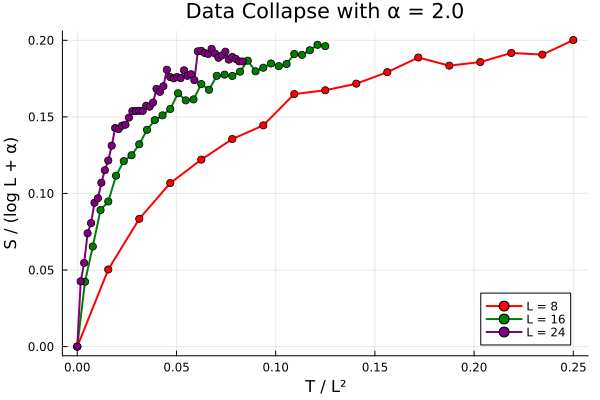


Creating corrected data collapse plot with optimal α = 2.0...


In [15]:
function plot_data_collapse_with_alpha(entropy_data::Dict, Ls::Vector{Int}, T_maxs::Vector{Int}, 
                                      alpha::Float64; title_suffix="")
    """
    Plot data collapse using S/(log L + α) normalization
    """
    plt = plot()
    colors = [:blue, :red, :green, :purple, :orange]
    
    for (idx, L) in enumerate(Ls)
        T_max = T_maxs[idx]
        color = colors[idx % length(colors) + 1]
        
        # Get raw entropy data and normalize with alpha
        S_raw, _ = entropy_data[L]
        S_normalized = S_raw ./ (log(L) + alpha)
        
        # Time axis
        time_axis = (0:T_max) ./ L^2
        
        plot!(plt, time_axis, S_normalized;
              label="L = $L", marker=:circle, markersize=4, linewidth=2, color=color)
    end
    
    xlabel!(plt, "T / L²")
    ylabel!(plt, "S / (log L + α)")
    title!(plt, "Data Collapse with α = $(round(alpha, digits=2))$title_suffix")
    plot!(plt, grid=true, gridwidth=1, gridcolor=:lightgray, gridalpha=0.5)
    
    return plt
end

# Create the corrected data collapse plot
println("\nCreating corrected data collapse plot with optimal α = $(round(optimal_alpha, digits=2))...")
corrected_plot = plot_data_collapse_with_alpha(entropy_data, Ls, T_maxs, optimal_alpha)
display(corrected_plot)

# binder parameter and chi

In [10]:
function chi_susceptibility(ψ::MPS, sites)
    # number of sites
    L = length(sites)
    
    # Calculate all 2-point correlations ⟨ZᵢZⱼ⟩ using correlator
    site_pairs = [(i, j) for i in 1:L for j in 1:L]
    z_correlations = correlator(ψ, ("Z", "Z"), site_pairs)
    
    # Chi susceptibility: χ = (1/L) Σᵢⱼ ⟨ZᵢZⱼ⟩²
    # Using your exact definition from the image
    chi = 0.0
    for i in 1:L, j in 1:L
        corr_val = real(z_correlations[(i, j)])
        chi += corr_val^2  # Square the correlation as per your formula
    end
    
    return chi / L
end


function create_up_state_mps(L::Int)
    sites = siteinds("S=1/2", L)
    state = ["Up" for _ in 1:L]
    ψ = productMPS(sites, state)
    return ψ, sites
end

create_up_state_mps (generic function with 1 method)

In [11]:
function run_single_trial_chi(seed::Int, L::Int, T_max::Int, lambda_x::Float64, lambda_zz::Float64; 
                             maxdim::Int=64, cutoff::Float64=1e-12)
    """
    Run a single trial and calculate chi susceptibility only
    Returns: chi
    """
    Random.seed!(seed)
    
    ψ, sites = create_up_state_mps(L)  # Changed to UP states as specified by user
    
    WEAK_X_0, WEAK_X_1, WEAK_ZZ_0, WEAK_ZZ_1 = create_weak_measurement_operators(sites, lambda_x, lambda_zz)
    
    # Evolution
    for t in 1:T_max
        for i in 1:L
            ψ = apply_weak_x_measurement(ψ, i, 1.0, WEAK_X_0, WEAK_X_1; 
                                        maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                return NaN
            end
        end
        for i in 1:(L-1)
            ψ = apply_weak_zz_measurement(ψ, i, i+1, 1.0, WEAK_ZZ_0, WEAK_ZZ_1;
                                         maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                return NaN
            end
        end
    end
    
    # Calculate chi susceptibility from the final state
    chi = chi_susceptibility(ψ, sites)
    
    return chi
end

function simulate_chi_vs_ratio(Ls::Vector{Int}, T_max::Int, lambda_zz_fixed::Float64, 
                              ratios::Vector{Float64}, num_trials::Int; 
                              seed::Int=42, maxdim::Int=64)
    """
    Simulate chi susceptibility for different ratios and system sizes
    Uses multithreading with progress bars for efficient computation
    Returns: all_chi_data
    """
    all_chi_data = Dict{Int, Vector{Float64}}()
    
    for L in Ls
        println("\nProcessing system size L = $L...")
        chi_results = Float64[]
        
        # Create progress bar for this system size
        total_computations = length(ratios) * num_trials
        progress = Progress(total_computations, desc="L=$L trials: ", dt=0.1, 
                          barglyphs=BarGlyphs("[=> ]"), barlen=40)
        
        for (ratio_idx, ratio) in enumerate(ratios)
            lambda_x = ratio * lambda_zz_fixed
            
            # Pre-allocate results array
            trial_results = Vector{Float64}(undef, num_trials)
            
            # Create seeds for reproducibility
            trial_seeds = [seed + trial + L * 1000 + round(Int, ratio * 100) for trial in 1:num_trials]
            
            # Run trials in parallel with progress tracking
            Threads.@threads for trial in 1:num_trials
                trial_results[trial] = run_single_trial_chi(
                    trial_seeds[trial], 
                    L, T_max, lambda_x, lambda_zz_fixed; 
                    maxdim=maxdim
                )
                
                # Update progress (thread-safe)
                next!(progress)
            end
            
            # Extract valid results
            chi_samples = filter(!isnan, trial_results)
            
            # Calculate averages
            if !isempty(chi_samples)
                avg_chi = mean(chi_samples)
                std_chi = std(chi_samples)
                push!(chi_results, avg_chi)
            else
                avg_chi = NaN
                std_chi = NaN
                push!(chi_results, NaN)
            end
            
            # Success rates
            chi_success_rate = length(chi_samples) / num_trials * 100
            
            # Print detailed results
            chi_str = isnan(avg_chi) ? "Failed" : "$(round(avg_chi, digits=6)) ± $(round(std_chi, digits=6))"
            
            println("  λx/λzz=$(round(ratio, digits=3)): χ=$chi_str ($(round(chi_success_rate,digits=1))%)")
        end
        
        finish!(progress)  # Complete the progress bar
        
        all_chi_data[L] = chi_results
        
        println("  ✓ Completed L=$L ($(length(ratios)) ratios × $num_trials trials = $(length(ratios)*num_trials) total)")
    end
    
    println("\n" * "="^70)
    println("✓ All chi simulations completed successfully!")
    
    return all_chi_data
end

simulate_chi_vs_ratio (generic function with 1 method)

In [12]:
function plot_chi_analysis(ratios::Vector{Float64}, 
                          all_chi_data::Dict{Int, Vector{Float64}})

    p_chi = plot(title="χ Susceptibility vs λx/λzz Ratio",
              xlabel="λx/λzz ratio", ylabel="χ Susceptibility", 
              grid=true, gridwidth=1, gridcolor=:lightgray, gridalpha=0.5,
              size=(700, 500), margin=5Plots.mm)
    
    colors = [:blue, :red, :green, :purple, :orange]
    
    for (idx, L) in enumerate(sort(collect(keys(all_chi_data))))
        color = colors[idx % length(colors) + 1]
        
        # Plot chi data
        chi_data = all_chi_data[L]
        valid_idx = findall(!isnan, chi_data)
        if !isempty(valid_idx)
            plot!(p_chi, ratios[valid_idx], chi_data[valid_idx],
                  marker=:circle, markersize=6, linewidth=2,
                  label="L = $L", color=color)
        end
    end

    return p_chi
end

plot_chi_analysis (generic function with 1 method)

In [26]:

Ls = [8, 16, 24]  # System sizes  
T_max = 50                  
lambda_zz_fixed = 0.5       
ratios = [0.1, 0.3, 0.5, 0.7, 1.0]  # λx/λzz ratios
num_trials = 50      
seed = 42          

total_simulations = length(Ls) * length(ratios) * num_trials

750

Running chi susceptibility simulation...
Running chi susceptibility simulation on 10 threads...
Parameters: T_max=50, λ_zz=0.5, trials=50

Processing system size L = 8...
Parameters: T_max=50, λ_zz=0.5, trials=50

Processing system size L = 8...


L=8 trials:  17%[======>                                 ]  ETA: 0:00:21

  λx/λzz=0.1: χ=7.709953 ± 0.50284 (100.0%)


L=8 trials:  37%[==============>                         ]  ETA: 0:00:14

  λx/λzz=0.3: χ=6.74866 ± 1.197713 (100.0%)


L=8 trials:  60%[=======================>                ]  ETA: 0:00:09

  λx/λzz=0.5: χ=5.688444 ± 1.338546 (100.0%)


L=8 trials:  74%[=============================>          ]  ETA: 0:00:06

  λx/λzz=0.7: χ=4.997149 ± 1.601577 (100.0%)


L=8 trials: 100%[========================================] Time: 0:00:21
L=8 trials: 100%[========================================] Time: 0:00:21


  λx/λzz=1.0: χ=4.103797 ± 1.11939 (100.0%)
  ✓ Completed L=8 (5 ratios × 50 trials = 250 total)

Processing system size L = 16...


L=16 trials:  17%[======>                                 ]  ETA: 0:01:10

  λx/λzz=0.1: χ=15.617847 ± 0.621832 (100.0%)


L=16 trials:  39%[===============>                        ]  ETA: 0:00:43

  λx/λzz=0.3: χ=13.628786 ± 1.694377 (100.0%)


L=16 trials:  57%[======================>                 ]  ETA: 0:00:32

  λx/λzz=0.5: χ=11.038626 ± 2.827428 (100.0%)


L=16 trials:  80%[================================>       ]  ETA: 0:00:16

  λx/λzz=0.7: χ=8.26587 ± 3.008925 (100.0%)


L=16 trials: 100%[========================================] Time: 0:01:26



  λx/λzz=1.0: χ=5.797038 ± 2.288197 (100.0%)
  ✓ Completed L=16 (5 ratios × 50 trials = 250 total)

Processing system size L = 24...


L=24 trials:  17%[======>                                 ]  ETA: 0:02:20

  λx/λzz=0.1: χ=23.517008 ± 0.682978 (100.0%)


L=24 trials:  38%[===============>                        ]  ETA: 0:01:39

  λx/λzz=0.3: χ=20.661127 ± 2.065236 (100.0%)


L=24 trials:  59%[=======================>                ]  ETA: 0:01:04

  λx/λzz=0.5: χ=16.76446 ± 3.544269 (100.0%)


L=24 trials:  80%[================================>       ]  ETA: 0:00:39

  λx/λzz=0.7: χ=11.121058 ± 3.658461 (100.0%)


L=24 trials: 100%[========================================] Time: 0:03:53
L=24 trials: 100%[========================================] Time: 0:03:53


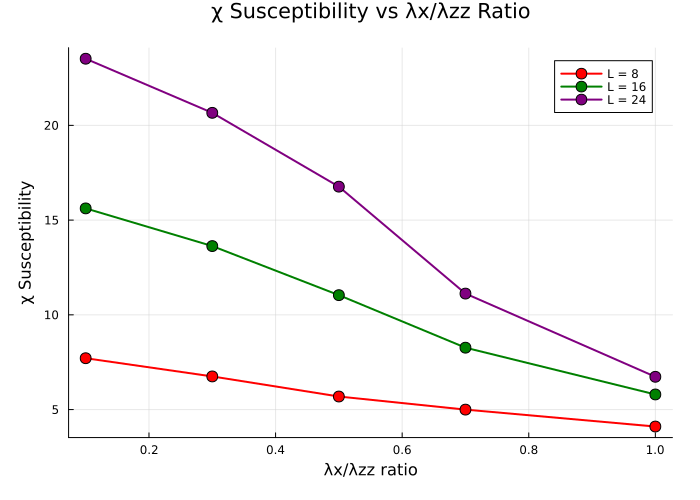

  λx/λzz=1.0: χ=6.72966 ± 2.173028 (100.0%)
  ✓ Completed L=24 (5 ratios × 50 trials = 250 total)

✓ All chi simulations completed successfully!

CHI SUSCEPTIBILITY ANALYSIS SUMMARY

System Size L = 8:
-^25
λx/λzz		χ Susceptibility
-^35
0.1		7.709953
0.3		6.74866
0.5		5.688444
0.7		4.997149
1.0		4.103797

System Size L = 16:
-^25
λx/λzz		χ Susceptibility
-^35
0.1		15.617847
0.3		13.628786
0.5		11.038626
0.7		8.26587
1.0		5.797038

System Size L = 24:
-^25
λx/λzz		χ Susceptibility
-^35
0.1		23.517008
0.3		20.661127
0.5		16.76446
0.7		11.121058
1.0		6.72966

CHI SUSCEPTIBILITY ANALYSIS SUMMARY

System Size L = 8:
-^25
λx/λzz		χ Susceptibility
-^35
0.1		7.709953
0.3		6.74866
0.5		5.688444
0.7		4.997149
1.0		4.103797

System Size L = 16:
-^25
λx/λzz		χ Susceptibility
-^35
0.1		15.617847
0.3		13.628786
0.5		11.038626
0.7		8.26587
1.0		5.797038

System Size L = 24:
-^25
λx/λzz		χ Susceptibility
-^35
0.1		23.517008
0.3		20.661127
0.5		16.76446
0.7		11.121058
1.0		6.72966



In [ ]:
# Generate the chi susceptibility simulation data
all_chi_data = simulate_chi_vs_ratio(Ls, T_max, lambda_zz_fixed, ratios, num_trials; 
                                    seed=seed, maxdim=64)

# Create and display the chi plot
chi_plot = plot_chi_analysis(ratios, all_chi_data)
display(chi_plot)

# Binder Parameter Analysis

In [13]:
function binder_parameter(ψ::MPS, sites)
    """
    Custom Binder cumulant from your note:

        B = 1 - [ (1/L^4) * Σ_{i,j,k,l} ⟨Z_i Z_j Z_k Z_l⟩^2 ] /
                  [ (3/L^4) * ( Σ_{i,j} ⟨Z_i Z_j⟩^2 )^2 ]

    - Includes i=j terms.
    - Uses "Z" operator (Qubit sites).
    """
    L = length(sites)

    # All index tuples
    site_pairs  = [(i,j) for i in 1:L for j in 1:L]
    site_quads  = [(i,j,k,l) for i in 1:L for j in 1:L for k in 1:L for l in 1:L]

    # Correlators
    z2 = correlator(ψ, ("Z","Z"), site_pairs)
    z4 = correlator(ψ, ("Z","Z","Z","Z"), site_quads)

    # Σ ⟨Z_i Z_j⟩^2
    sum2_sq = 0.0
    @inbounds for (i,j) in site_pairs
        v = real(z2[(i,j)])
        sum2_sq += v*v
    end

    # Σ ⟨Z_i Z_j Z_k Z_l⟩^2
    sum4_sq = 0.0
    @inbounds for (i,j,k,l) in site_quads
        v = real(z4[(i,j,k,l)])
        sum4_sq += v*v
    end

    # Your Binder definition
    numerator   = (sum4_sq / L^4)
    denominator = (3.0 / L^4) * (sum2_sq^2)

    if !(isfinite(denominator)) || abs(denominator) < 1e-14
        return NaN
    end

    B = 1.0 - numerator / denominator
    return B
end


binder_parameter (generic function with 1 method)

In [14]:
function run_single_trial_binder(seed::Int, L::Int, T_max::Int, lambda_x::Float64, lambda_zz::Float64; 
                                maxdim::Int=64, cutoff::Float64=1e-12)
    Random.seed!(seed)
    
    ψ, sites = create_up_state_mps(L)
    
    WEAK_X_0, WEAK_X_1, WEAK_ZZ_0, WEAK_ZZ_1 = create_weak_measurement_operators(sites, lambda_x, lambda_zz)
    
    for t in 1:T_max
        for i in 1:L
            ψ = apply_weak_x_measurement(ψ, i, 1.0, WEAK_X_0, WEAK_X_1; 
                                        maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                return NaN
            end
        end
        for i in 1:(L-1)
            ψ = apply_weak_zz_measurement(ψ, i, i+1, 1.0, WEAK_ZZ_0, WEAK_ZZ_1;
                                         maxdim=maxdim, cutoff=cutoff)
            if ψ === nothing
                return NaN
            end
        end
    end
    
    binder = binder_parameter(ψ, sites)
    
    return binder
end

function simulate_binder_vs_lambda(Ls::Vector{Int}, T_max::Int, lambdas::Vector{Float64}, 
                                   num_trials::Int; seed::Int=42, maxdim::Int=64)
    all_binder_data = Dict{Int, Vector{Float64}}()
    
    for L in Ls
        println("\nProcessing system size L = $L for Binder parameter...")
        binder_results = Float64[]
        
        # Create progress bar for this system size
        total_computations = length(lambdas) * num_trials
        progress = Progress(total_computations, desc="L=$L Binder trials: ", dt=0.1, 
                          barglyphs=BarGlyphs("[=> ]"), barlen=40)
        
        for (lambda_idx, lambda) in enumerate(lambdas)
            lambda_x = lambda
            lambda_zz = 1.0 - lambda
            
            trial_results = Vector{Float64}(undef, num_trials)
            
            trial_seeds = [seed + trial + L * 2000 + round(Int, lambda * 100) for trial in 1:num_trials]
            
            Threads.@threads for trial in 1:num_trials
                trial_results[trial] = run_single_trial_binder(
                    trial_seeds[trial], 
                    L, T_max, lambda_x, lambda_zz; 
                    maxdim=maxdim
                )
                next!(progress)
            end
            
            # Extract valid results with enhanced filtering
            raw_binder_samples = filter(!isnan, trial_results)
            
            # Additional physical filtering for Binder parameters
            # Remove extreme outliers that are likely numerical artifacts
            if !isempty(raw_binder_samples)
                # Calculate median and MAD (Median Absolute Deviation) for robust outlier detection
                median_val = median(raw_binder_samples)
                mad_val = median(abs.(raw_binder_samples .- median_val))
                
                # Filter out values more than 5 MAD from median (robust outlier detection)
                # This is more robust than standard deviation for heavy-tailed distributions
                if mad_val > 1e-10  # Only apply if MAD is meaningful
                    threshold = 5.0 * mad_val
                    binder_samples = filter(x -> abs(x - median_val) <= threshold, raw_binder_samples)
                else
                    binder_samples = raw_binder_samples
                end
                
                # Additional bounds check for physical reasonableness
                binder_samples = filter(x -> x >= -0.1 && x <= 1.0, binder_samples)
            else
                binder_samples = raw_binder_samples
            end
            
            if !isempty(binder_samples)
                avg_binder = mean(binder_samples)
                std_binder = std(binder_samples)
                push!(binder_results, avg_binder)
            else
                avg_binder = NaN
                std_binder = NaN
                push!(binder_results, NaN)
            end
            
            binder_success_rate = length(binder_samples) / num_trials * 100
            raw_success_rate = length(raw_binder_samples) / num_trials * 100
            filtered_count = length(raw_binder_samples) - length(binder_samples)
            
            binder_str = isnan(avg_binder) ? "Failed" : "$(round(avg_binder, digits=4)) ± $(round(std_binder, digits=4))"
            
            println("  λ=$(round(lambda, digits=3)) (λₓ=$(round(lambda_x, digits=3)), λ_zz=$(round(lambda_zz, digits=3))): β=$binder_str ($(round(binder_success_rate,digits=1))% valid, $(filtered_count) filtered)")
        end
        
        finish!(progress)
        
        all_binder_data[L] = binder_results
        
        println("  ✓ Completed L=$L ($(length(lambdas)) λ values × $num_trials trials = $(length(lambdas)*num_trials) total)")
    end
    
    println("\n" * "="^70)
    println("✓ All Binder parameter simulations completed successfully!")
    println("Note: Results filtered for numerical stability and physical reasonableness")
    println("Parameter scheme: λₓ = λ, λ_zz = 1-λ")
    
    return all_binder_data
end

simulate_binder_vs_lambda (generic function with 1 method)

In [15]:
function plot_binder_analysis_lambda(lambdas::Vector{Float64}, 
                                    all_binder_data::Dict{Int, Vector{Float64}})

    p_binder = plot(title="Binder Parameter vs λ (λₓ=λ, λ_zz=1-λ)\nLook for crossing points indicating critical transitions",
                   xlabel="λ", ylabel="Binder Parameter", 
                   grid=true, gridwidth=1, gridcolor=:lightgray, gridalpha=0.5,
                   size=(800, 600), margin=5Plots.mm)
    
    colors = [:blue, :red, :green, :purple, :orange]
    markers = [:circle, :square, :diamond, :triangle, :star5]
    
    all_x_data = Float64[]
    all_y_data = Float64[]
    
    for (idx, L) in enumerate(sort(collect(keys(all_binder_data))))
        color = colors[idx % length(colors) + 1]
        marker = markers[idx % length(markers) + 1]
        
        binder_data = all_binder_data[L]
        valid_idx = findall(!isnan, binder_data)
        if !isempty(valid_idx)
            x_vals = lambdas[valid_idx]
            y_vals = binder_data[valid_idx]
            
            plot!(p_binder, x_vals, y_vals,
                  marker=marker, markersize=6, linewidth=3,
                  label="L = $L", color=color, alpha=0.8)
            
            append!(all_x_data, x_vals)
            append!(all_y_data, y_vals)
        end
    end
    
    # Set dynamic axis limits with minimal padding for close data
    if !isempty(all_x_data) && !isempty(all_y_data)
        x_min, x_max = minimum(all_x_data), maximum(all_x_data)
        y_min, y_max = minimum(all_y_data), maximum(all_y_data)
        
        # For closely spaced data, use minimal padding
        x_range = x_max - x_min
        y_range = y_max - y_min
        
        x_padding = max(0.02 * x_range, 0.005)  # 2% padding, min 0.005
        y_padding = max(0.02 * y_range, 0.002)  # 2% padding, min 0.002
        
        if y_range < 0.01
            y_padding = max(y_padding, 0.001)
        end
        
        plot!(xlims=(x_min - x_padding, x_max + x_padding),
              ylims=(y_min - y_padding, y_max + y_padding))
    end
    
    # Add a vertical line at λ = 0.5 as a reference (if it's within the data range)
    if !isempty(all_x_data)
        x_min_data, x_max_data = minimum(all_x_data), maximum(all_x_data)
        if 0.5 >= x_min_data && 0.5 <= x_max_data
            y_min_plot, y_max_plot = ylims(p_binder)
            plot!(p_binder, [0.5, 0.5], [y_min_plot, y_max_plot], 
                  linestyle=:dot, color=:gray, alpha=0.7,
                  label="λ = 0.5 (balanced)", linewidth=1)
        end
    end
    
    plot!(legendfontsize=10, guidefontsize=12, titlefontsize=11)

    return p_binder
end

plot_binder_analysis_lambda (generic function with 1 method)

In [16]:
Ls_binder = [8, 12, 16] 
T_max_binder = 50                  
lambdas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_trials_binder = 50
seed_binder = 42          

all_binder_data = simulate_binder_vs_lambda(Ls_binder, T_max_binder, lambdas, num_trials_binder; 
                                           seed=seed_binder, maxdim=64)




Processing system size L = 8 for Binder parameter...


L=8 Binder trials:  10%[====>                                   ]  ETA: 0:03:28

  λ=0.1 (λₓ=0.1, λ_zz=0.9): β=0.6667 ± 0.0 (84.0% valid, 8 filtered)


L=8 Binder trials:  20%[========>                               ]  ETA: 0:02:00

  λ=0.2 (λₓ=0.2, λ_zz=0.8): β=0.6665 ± 0.0001 (58.0% valid, 21 filtered)


L=8 Binder trials:  33%[=============>                          ]  ETA: 0:01:18

  λ=0.3 (λₓ=0.3, λ_zz=0.7): β=0.641 ± 0.0302 (94.0% valid, 3 filtered)


L=8 Binder trials:  44%[=================>                      ]  ETA: 0:01:00

  λ=0.4 (λₓ=0.4, λ_zz=0.6): β=0.5539 ± 0.0893 (100.0% valid, 0 filtered)


L=8 Binder trials:  56%[======================>                 ]  ETA: 0:00:44

  λ=0.5 (λₓ=0.5, λ_zz=0.5): β=0.4448 ± 0.0988 (100.0% valid, 0 filtered)


L=8 Binder trials:  66%[==========================>             ]  ETA: 0:00:32

  λ=0.6 (λₓ=0.6, λ_zz=0.4): β=0.2802 ± 0.0286 (78.0% valid, 11 filtered)


L=8 Binder trials:  77%[==============================>         ]  ETA: 0:00:21

  λ=0.7 (λₓ=0.7, λ_zz=0.3): β=0.1912 ± 0.0042 (76.0% valid, 12 filtered)


L=8 Binder trials:  87%[==================================>     ]  ETA: 0:00:12

  λ=0.8 (λₓ=0.8, λ_zz=0.2): β=0.1304 ± 0.0008 (84.0% valid, 8 filtered)


L=8 Binder trials: 100%[========================================] Time: 0:01:24


  λ=0.9 (λₓ=0.9, λ_zz=0.1): β=0.095 ± 0.0 (90.0% valid, 5 filtered)
  ✓ Completed L=8 (9 λ values × 50 trials = 450 total)

Processing system size L = 12 for Binder parameter...


L=12 Binder trials:  11%[====>                                   ]  ETA: 0:03:33

  λ=0.1 (λₓ=0.1, λ_zz=0.9): β=0.6667 ± 0.0 (78.0% valid, 11 filtered)


L=12 Binder trials:  22%[========>                               ]  ETA: 0:03:12

  λ=0.2 (λₓ=0.2, λ_zz=0.8): β=0.6665 ± 0.0002 (78.0% valid, 11 filtered)


L=12 Binder trials:  33%[=============>                          ]  ETA: 0:02:46

  λ=0.3 (λₓ=0.3, λ_zz=0.7): β=0.6503 ± 0.018 (86.0% valid, 7 filtered)


L=12 Binder trials:  44%[=================>                      ]  ETA: 0:02:21

  λ=0.4 (λₓ=0.4, λ_zz=0.6): β=0.5685 ± 0.0813 (96.0% valid, 2 filtered)


L=12 Binder trials:  55%[======================>                 ]  ETA: 0:01:55

  λ=0.5 (λₓ=0.5, λ_zz=0.5): β=0.4139 ± 0.122 (100.0% valid, 0 filtered)


L=12 Binder trials:  67%[==========================>             ]  ETA: 0:01:25

  λ=0.6 (λₓ=0.6, λ_zz=0.4): β=0.2281 ± 0.048 (92.0% valid, 4 filtered)


L=12 Binder trials:  76%[==============================>         ]  ETA: 0:01:02

  λ=0.7 (λₓ=0.7, λ_zz=0.3): β=0.1372 ± 0.0104 (88.0% valid, 6 filtered)


L=12 Binder trials:  87%[==================================>     ]  ETA: 0:00:33

  λ=0.8 (λₓ=0.8, λ_zz=0.2): β=0.0888 ± 0.0007 (80.0% valid, 10 filtered)


L=12 Binder trials: 100%[========================================] Time: 0:04:13


  λ=0.9 (λₓ=0.9, λ_zz=0.1): β=0.0637 ± 0.0 (94.0% valid, 3 filtered)
  ✓ Completed L=12 (9 λ values × 50 trials = 450 total)

Processing system size L = 16 for Binder parameter...


L=16 Binder trials:  10%[===>                                    ]  ETA: 0:13:18

  λ=0.1 (λₓ=0.1, λ_zz=0.9): β=0.6667 ± 0.0 (76.0% valid, 12 filtered)


L=16 Binder trials:  22%[========>                               ]  ETA: 0:10:30

  λ=0.2 (λₓ=0.2, λ_zz=0.8): β=0.6665 ± 0.0002 (64.0% valid, 18 filtered)


L=16 Binder trials:  33%[=============>                          ]  ETA: 0:08:57

  λ=0.3 (λₓ=0.3, λ_zz=0.7): β=0.6572 ± 0.0097 (82.0% valid, 9 filtered)


L=16 Binder trials:  44%[=================>                      ]  ETA: 0:07:31

  λ=0.4 (λₓ=0.4, λ_zz=0.6): β=0.5452 ± 0.0993 (98.0% valid, 1 filtered)


L=16 Binder trials:  55%[=====================>                  ]  ETA: 0:06:17

  λ=0.5 (λₓ=0.5, λ_zz=0.5): β=0.3775 ± 0.1146 (100.0% valid, 0 filtered)


L=16 Binder trials:  67%[==========================>             ]  ETA: 0:04:35

  λ=0.6 (λₓ=0.6, λ_zz=0.4): β=0.1899 ± 0.0332 (96.0% valid, 2 filtered)


L=16 Binder trials:  78%[===============================>        ]  ETA: 0:03:02

  λ=0.7 (λₓ=0.7, λ_zz=0.3): β=0.1079 ± 0.0097 (86.0% valid, 7 filtered)


L=16 Binder trials:  89%[===================================>    ]  ETA: 0:01:31

  λ=0.8 (λₓ=0.8, λ_zz=0.2): β=0.0672 ± 0.0005 (86.0% valid, 7 filtered)


L=16 Binder trials: 100%[========================================] Time: 0:13:35


  λ=0.9 (λₓ=0.9, λ_zz=0.1): β=0.0479 ± 0.0 (90.0% valid, 5 filtered)
  ✓ Completed L=16 (9 λ values × 50 trials = 450 total)

✓ All Binder parameter simulations completed successfully!
Note: Results filtered for numerical stability and physical reasonableness
Parameter scheme: λₓ = λ, λ_zz = 1-λ


Dict{Int64, Vector{Float64}} with 3 entries:
  16 => [0.666664, 0.666495, 0.657207, 0.545163, 0.377516, 0.189905, 0.107872, …
  12 => [0.666663, 0.666482, 0.650334, 0.568519, 0.413945, 0.228089, 0.137198, …
  8  => [0.666659, 0.666499, 0.64104, 0.55391, 0.444843, 0.280161, 0.191214, 0.…

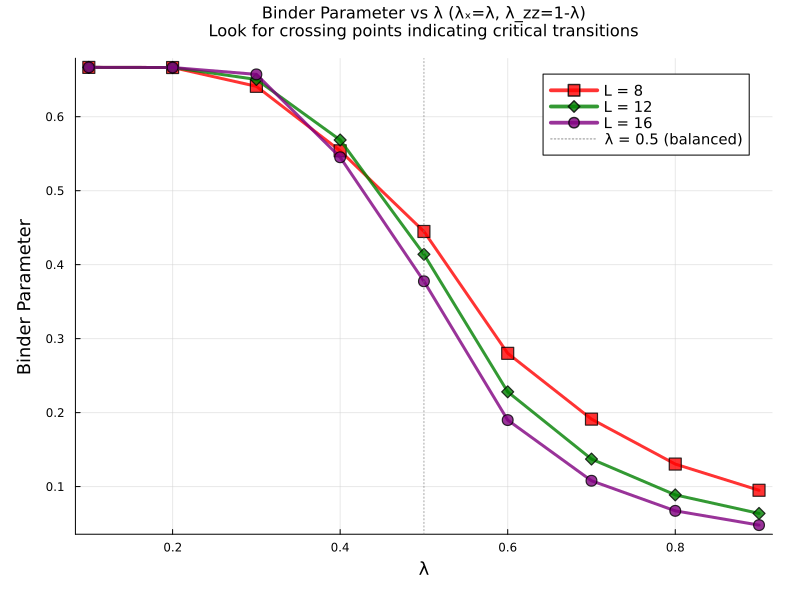

┌ Warning: Skipped marker arg triangle.
└ @ Plots /Users/qiawang/.julia/packages/Plots/zgMHY/src/args.jl:1155


In [17]:
# Create and display the Binder plot
binder_plot = plot_binder_analysis_lambda(lambdas, all_binder_data)
display(binder_plot)

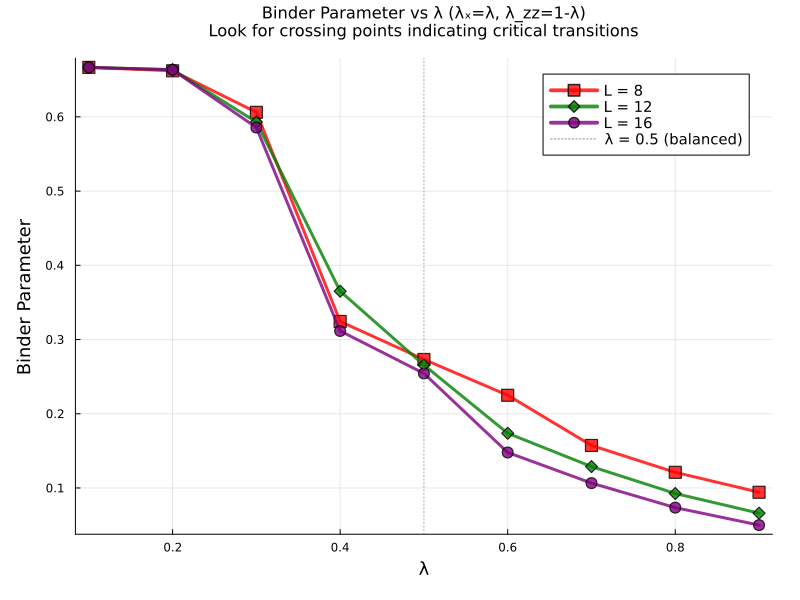

┌ Warning: Skipped marker arg triangle.
└ @ Plots /Users/qiawang/.julia/packages/Plots/zgMHY/src/args.jl:1155


In [17]:
# Create and display the Binder plot
binder_plot = plot_binder_analysis_lambda(lambdas, all_binder_data)
display(binder_plot)